In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil, floor
from datetime import datetime 
torch.manual_seed(123)

# Model definition

In [3]:
# Model definition
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Training on device {device}.")

class LocalizationModel(nn.Module):
    def __init__(self, num_classes=10):
        super(LocalizationModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 12 * 15, 128)  # Adjusted for input size 48x60
        self.fc2 = nn.Linear(128, num_classes + 5)  # C + 5 outputs

    def forward(self, x):
        x = F.relu(self.conv1(x))  # [batch_size, 32, 48, 60]
        x = F.max_pool2d(x, 2)  # [batch_size, 32, 24, 30]
        x = F.relu(self.conv2(x))  # [batch_size, 64, 24, 30]
        x = F.max_pool2d(x, 2)  # [batch_size, 64, 12, 15]
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, 64 * 12 * 15]
        x = F.relu(self.fc1(x))  # [batch_size, 128]
        x = self.fc2(x)  # [batch_size, num_classes + 5]
        return x
    
# Making and improved model for evaluating.
class ImprovedLocalizationModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedLocalizationModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 6 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_pc = nn.Linear(128, 1)  # Output for pc (object presence)
        self.fc_bbox = nn.Linear(128, 4)  # Output for [x, y, w, h]
        self.fc_classes = nn.Linear(128, num_classes)  # Output for [c1, c2, ..., c10]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch_size, 32, 24, 30]
        x = self.pool(F.relu(self.conv2(x)))  # [batch_size, 64, 12, 15]
        x = self.pool(F.relu(self.conv3(x)))  # [batch_size, 128, 6, 7]
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, 128 * 6 * 7]
        x = F.relu(self.fc1(x))  # [batch_size, 256]
        x = F.relu(self.fc2(x))  # [batch_size, 128]
        
        # Output all components
        pc = torch.sigmoid(self.fc_pc(x))  # [batch_size, 1]
        bbox = self.fc_bbox(x)  # [batch_size, 4]
        classes = self.fc_classes(x)  # [batch_size, num_classes]
        
        # Concatenate all outputs
        output = torch.cat([pc, bbox, classes], dim=1)  # [batch_size, 1 + 4 + num_classes]
        return output
    

torch.manual_seed(123)
model = LocalizationModel().to(device)
torch.manual_seed(123)
improved_model = ImprovedLocalizationModel().to(device)

Training on device cuda.


## Localization


In [4]:
def localization_loss(y_pred, y_true):
    # Extract components from y_pred (has format [pc, x, y, w, h, c1, c2, ..., c10])
    pred_pc = y_pred[:, 0]
    pred_bbox = y_pred[:, 1:5]  # [x, y, w, h]
    pred_classes = y_pred[:, 5:]  # [c1, c2, ..., c10]
    
    # Extract components from y_true (has format [pc, x, y, w, h, c])
    true_pc = y_true[:, 0]
    true_bbox = y_true[:, 1:5]  # [x, y, w, h]
    true_class = y_true[:, 5].long()  # Convert class index to long
    
    # Detection loss (binary cross entropy with logits)
    detection_loss = F.binary_cross_entropy_with_logits(pred_pc, true_pc)
    
    # Calculate bbox loss and classification loss only when an object is present
    def when_object_present():
        # Bounding box loss (MSE)
        bbox_loss = F.mse_loss(pred_bbox, true_bbox)
        
        # Classification loss (cross entropy)
        class_loss = F.cross_entropy(pred_classes, true_class)
        
        return detection_loss + bbox_loss + class_loss
    
    # When no object is present, only use detection loss
    def when_no_object():
        return detection_loss
    
    # Use torch.where to conditionally compute the loss
    losses = torch.where(
        true_pc.bool(),
        when_object_present(),
        when_no_object()
    )
    
    # Return the mean loss across the batch
    return losses.mean()



### Load data and preprocessing

In [5]:
def load_data():
    # Load the datasets
    train_dataset = torch.load('data/localization_train.pt')
    val_dataset = torch.load('data/localization_val.pt')
    test_dataset = torch.load('data/localization_test.pt')

    # Ensure it's a TensorDataset
    print(f"Train dataset type: {type(train_dataset)}")
    print(f"Validation dataset type: {type(val_dataset)}")
    print(f"Test dataset type: {type(test_dataset)}")

    # Unpack tensors from TensorDataset
    X_train, y_train = train_dataset.tensors
    X_val, y_val = val_dataset.tensors
    X_test, y_test = test_dataset.tensors

    # Print shapes
    print(f"Train images shape: {X_train.shape}, Train targets shape: {y_train.shape}")
    print(f"Validation images shape: {X_val.shape}, Validation targets shape: {y_val.shape}")
    print(f"Test images shape: {X_test.shape}, Test targets shape: {y_test.shape}")

    return X_train, y_train, X_val, y_val, X_test, y_test

# Load data
X_train, y_train, X_val, y_val, X_test, y_test = load_data()


Train dataset type: <class 'torch.utils.data.dataset.TensorDataset'>
Validation dataset type: <class 'torch.utils.data.dataset.TensorDataset'>
Test dataset type: <class 'torch.utils.data.dataset.TensorDataset'>
Train images shape: torch.Size([59400, 1, 48, 60]), Train targets shape: torch.Size([59400, 6])
Validation images shape: torch.Size([6600, 1, 48, 60]), Validation targets shape: torch.Size([6600, 6])
Test images shape: torch.Size([11000, 1, 48, 60]), Test targets shape: torch.Size([11000, 6])


### Normalize Images

In [6]:
def normalize_images(images):
    mean = images.mean()
    std = images.std()
    transform = transforms.Normalize(mean, std)
    return transform(images)

X_train = normalize_images(X_train)
X_val = normalize_images(X_val)
X_test = normalize_images(X_test)

### Training

In [7]:
def train(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=64, lr=0.001):
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    torch.manual_seed(123)  # Jupyter bug fix
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    torch.manual_seed(123)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=lr) #Adam

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = localization_loss(output, labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

train(model, X_train, y_train, X_val, y_val)
train(improved_model,X_train, y_train, X_val, y_val)


Epoch 1, Loss: 1.0078456401824951
Epoch 2, Loss: 1.2627968788146973
Epoch 3, Loss: 1.3578505516052246
Epoch 4, Loss: 0.5235161185264587
Epoch 5, Loss: 0.467105507850647
Epoch 6, Loss: 0.29509276151657104
Epoch 7, Loss: 0.10456995666027069
Epoch 8, Loss: 0.2352285385131836
Epoch 9, Loss: 0.3303145170211792
Epoch 10, Loss: 0.4748302102088928
Epoch 1, Loss: 0.7967166900634766
Epoch 2, Loss: 0.3954337239265442
Epoch 3, Loss: 0.5363789796829224
Epoch 4, Loss: 0.49200737476348877
Epoch 5, Loss: 0.4656900465488434
Epoch 6, Loss: 1.1263012886047363
Epoch 7, Loss: 0.49718141555786133
Epoch 8, Loss: 0.48211783170700073
Epoch 9, Loss: 0.3886512517929077
Epoch 10, Loss: 0.3738596439361572


### Predictions

In [8]:
def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image)
        pc_pred = torch.sigmoid(output[0, 0])
        bb_pred = output[0, 1:5]
        class_pred = torch.argmax(output[0, 5:])
        return pc_pred, bb_pred, class_pred
    
predict(model, X_test[0])
predict(improved_model, X_test[0])

(tensor(0.7311, device='cuda:0'),
 tensor([0.4500, 0.2938, 0.2367, 0.3078], device='cuda:0'),
 tensor(5, device='cuda:0'))

### Model selection and evaluation

In [9]:
def intersection(bb1, bb2):
    """
    Compute intersection between 2 bounding boxes in global frame of reference
    
    bb1, bb2: tensors of shape [x, y, w, h] where:
    - (x, y) is the center point
    - w is width
    - h is height
    """
    # Convert from center format to corner format
    bb1_x1 = bb1[0] - bb1[2]/2
    bb1_y1 = bb1[1] - bb1[3]/2
    bb1_x2 = bb1[0] + bb1[2]/2
    bb1_y2 = bb1[1] + bb1[3]/2
    
    bb2_x1 = bb2[0] - bb2[2]/2
    bb2_y1 = bb2[1] - bb2[3]/2
    bb2_x2 = bb2[0] + bb2[2]/2
    bb2_y2 = bb2[1] + bb2[3]/2
    
    # Calculate intersection coordinates
    x1 = max(bb1_x1, bb2_x1)
    y1 = max(bb1_y1, bb2_y1)
    x2 = min(bb1_x2, bb2_x2)
    y2 = min(bb1_y2, bb2_y2)
    
    # Check if there is an intersection
    if x2 < x1 or y2 < y1:
        return 0.0
    
    # Calculate intersection area
    return (x2 - x1) * (y2 - y1)

def IoU(bb1, bb2):
    """
    Compute IoU given 2 bounding boxes
    
    bb1, bb2: tensors of shape [x, y, w, h]
    """
    # Area of the first bounding box
    area_bb1 = bb1[2] * bb1[3]
    
    # Area of the second bounding box
    area_bb2 = bb2[2] * bb2[3]
    
    # Intersection area
    inter_area = intersection(bb1, bb2)
    
    # IoU calculation: intersection area / union area
    # Union = area_bb1 + area_bb2 - intersection area
    union_area = area_bb1 + area_bb2 - inter_area
    
    # Avoid division by zero
    if union_area < 1e-5:
        return 0.0
    
    return inter_area / union_area

def compute_IoU_localization(model, loader):
    """
    Compute IoU performance of the model on the given dataset
    """
    model.eval()
    total_iou = 0.0
    count = 0
    
    with torch.no_grad():
        for data, target in loader:
            # Normalize data
            data = normalize_images(data)
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Only consider images with objects
            mask = target[:, 0] == 1
            if not torch.any(mask):
                continue
                
            # For images with objects, calculate IoU
            pred_bboxes = output[mask, 1:5]
            true_bboxes = target[mask, 1:5]
            
            # Sigmoid for x, y and ensure w, h are positive
            pred_bboxes[:, 0:2] = torch.sigmoid(pred_bboxes[:, 0:2])
            pred_bboxes[:, 2:4] = torch.abs(pred_bboxes[:, 2:4])
            
            # Calculate IoU for each image
            for pred_bbox, true_bbox in zip(pred_bboxes, true_bboxes):
                total_iou += IoU(pred_bbox.cpu(), true_bbox.cpu())
                count += 1
    
    return total_iou / count if count > 0 else 0.0

def compute_accuracy_localization(model, loader):
    """
    Compute accuracy of the model on the given dataset
    """
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in loader:
            # Normalize data
            data = normalize_images(data)
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Only consider images with objects (pc=1)
            mask = target[:, 0] == 1
            if not torch.any(mask):
                continue
            
            # Get predictions for images with objects
            pred_pc = torch.sigmoid(output[mask, 0]) > 0.5
            pred_classes = torch.argmax(output[mask, 5:], dim=1)
            true_classes = target[mask, 5].long()
            
            # An image is correctly classified if pc is correct and class is correct
            correct_predictions = (pred_pc == 1) & (pred_classes == true_classes)
            correct += torch.sum(correct_predictions).item()
            total += mask.sum().item()
    
    return correct / total if total > 0 else 0.0

# Evaluation

In [10]:
def evaluate_model(model, loader, name="Model"):
    """
    Evaluate the model on the given data loader.
    
    Args:
        model: The model to evaluate.
        loader: DataLoader for the dataset to evaluate on.
        name: Name of the model for printing purposes.
    
    Returns:
        overall_loss: The average loss over the dataset.
        accuracy: The classification accuracy.
        iou: The average IoU over the dataset.
    """
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    correct = 0
    total = 0
    count = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Compute loss
            loss = localization_loss(output, target)
            total_loss += loss.item()
            
            # Only consider images with objects (pc=1)
            mask = target[:, 0] == 1
            if not torch.any(mask):
                continue
            
            # For images with objects, calculate IoU and accuracy
            pred_pc = torch.sigmoid(output[mask, 0]) > 0.5
            pred_bboxes = output[mask, 1:5]
            pred_classes = torch.argmax(output[mask, 5:], dim=1)
            
            true_bboxes = target[mask, 1:5]
            true_classes = target[mask, 5].long()
            
            # Sigmoid for x, y and ensure w, h are positive
            pred_bboxes[:, 0:2] = torch.sigmoid(pred_bboxes[:, 0:2])
            pred_bboxes[:, 2:4] = torch.abs(pred_bboxes[:, 2:4])
            
            # Calculate IoU for each image
            for pred_bbox, true_bbox in zip(pred_bboxes, true_bboxes):
                total_iou += IoU(pred_bbox.cpu(), true_bbox.cpu())
                count += 1
            
            # Calculate accuracy
            correct_predictions = (pred_pc == 1) & (pred_classes == true_classes)
            correct += torch.sum(correct_predictions).item()
            total += mask.sum().item()
    
    # Compute averages
    overall_loss = total_loss / len(loader)
    accuracy = correct / total if total > 0 else 0.0
    iou = total_iou / count if count > 0 else 0.0
    
    # Print results
    print(f"{name} Evaluation:")
    print(f"  Overall Loss: {overall_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  IoU: {iou:.4f}")
    
    return overall_loss, accuracy, iou



test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
overall_loss, accuracy, iou = evaluate_model(model, test_loader, name="Basic CNN")
overall_loss_improved, accuracy_improved, iou_improved = evaluate_model(improved_model, test_loader, name="Improved CNN")

Basic CNN Evaluation:
  Overall Loss: 0.7122
  Accuracy: 0.7377
  IoU: 0.1369
Improved CNN Evaluation:
  Overall Loss: 0.6764
  Accuracy: 0.9147
  IoU: 0.1498


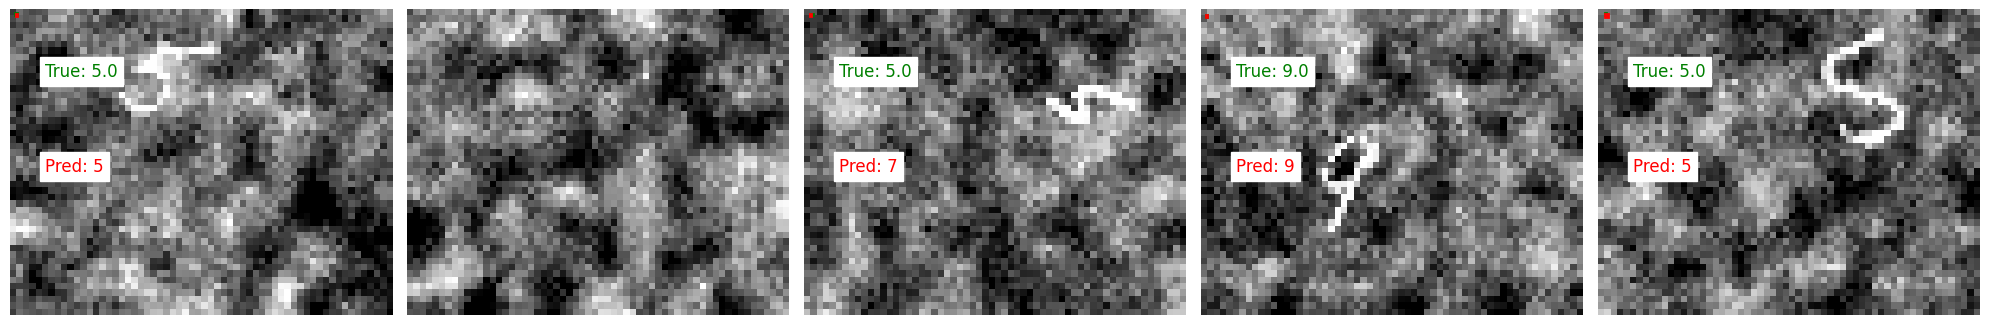

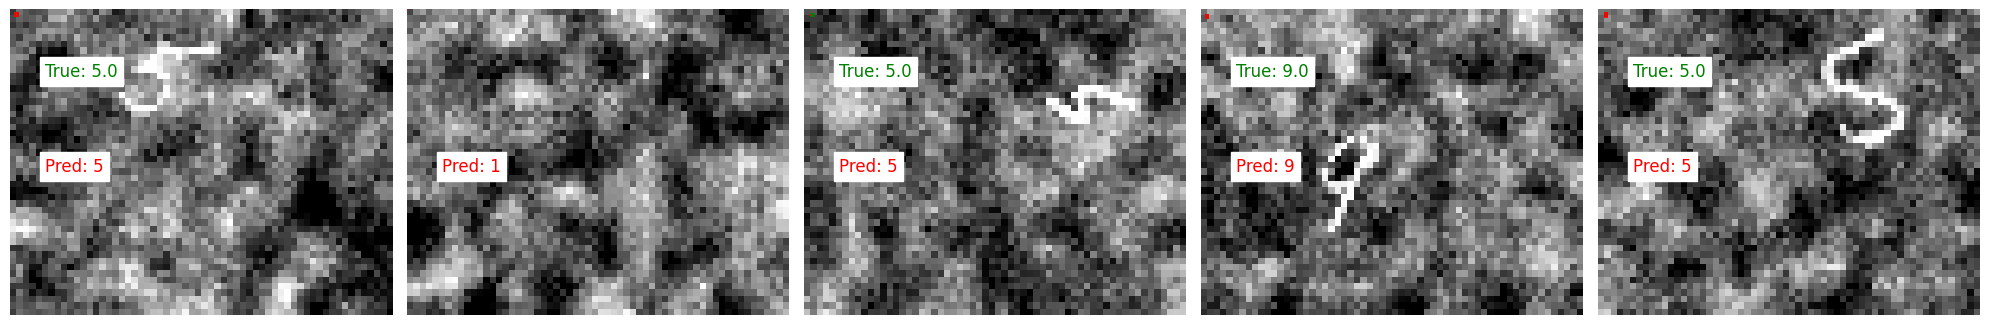

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_images_with_bboxes(model, dataset, num_images=5):
    """
    Plot images with true and predicted bounding boxes and labels.
    
    Args:
        model: The model to use for predictions.
        dataset: The dataset (TensorDataset) containing images and labels.
        num_images: Number of images to plot.
    """
    model.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    
    for i in range(num_images):
        image, target = dataset[i]
        image = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image)
        
        # Extract predictions
        pred_pc = torch.sigmoid(output[0, 0]).item()
        pred_bbox = output[0, 1:5].cpu()
        pred_class = torch.argmax(output[0, 5:]).item()
        
        # Extract true values
        true_pc = target[0].item()
        true_bbox = target[1:5].cpu()
        true_class = target[5].item()
        
        # Convert image to numpy and remove batch dimension
        image = image.squeeze(0).cpu().permute(1, 2, 0).numpy()
        
        # Plot the image
        ax = axes[i]
        ax.imshow(image, cmap='gray')
        
        # Draw true bounding box
        if true_pc == 1:
            true_x, true_y, true_w, true_h = true_bbox
            true_rect = patches.Rectangle(
                (true_x - true_w / 2, true_y - true_h / 2), true_w, true_h,
                linewidth=2, edgecolor='g', facecolor='none', label='True'
            )
            ax.add_patch(true_rect)
            ax.text(5, 10, f'True: {true_class}', color='green', fontsize=12, backgroundcolor='white')
        
        # Draw predicted bounding box
        if pred_pc > 0.5:
            pred_x, pred_y, pred_w, pred_h = pred_bbox
            pred_rect = patches.Rectangle(
                (pred_x - pred_w / 2, pred_y - pred_h / 2), pred_w, pred_h,
                linewidth=2, edgecolor='r', facecolor='none', label='Pred'
            )
            ax.add_patch(pred_rect)
            ax.text(5, 25, f'Pred: {pred_class}', color='red', fontsize=12, backgroundcolor='white')
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
plot_images_with_bboxes(model, test_dataset, num_images=5)
plot_images_with_bboxes(improved_model, test_dataset, num_images=5)